In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

import paragami
import vittles

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [17]:
fit_dir = '/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/jupyter/fits'

refitfile = os.path.join(fit_dir,
    'transformed_gene_regression_df4_degree3_genes700_num_components30_inflate1.0_shrunkTrue_refit.npz')

with np.load(refitfile) as infile:
    initial_fitfile = str(infile['input_filename'])
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    reopt_gmm_params = gmm_params_pattern.fold(
        infile['reopt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['reopt_prior_params_pattern_json']))
    reopt_prior_params = prior_params_pattern.fold(
        infile['reopt_prior_params_flat'], free=False)
    reopt_time = infile['reopt_time']

with np.load(initial_fitfile) as infile:
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    opt_gmm_params = gmm_params_pattern.fold(
        infile['opt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['prior_params_pattern_json']))
    prior_params = prior_params_pattern.fold(
        infile['prior_params_flat'], free=False)
    kl_hess = infile['kl_hess']
    df = infile['df']
    degree = infile['degree']
    datafile = str(infile['datafile'])
    num_components = int(infile['num_components'])

reg_params = dict()
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)

    
print('New alpha: ', np.unique(reopt_prior_params['probs_alpha']))
num_genes = reg_params['beta_mean'].shape[0]

gmm = gmm_lib.GMM(num_components, reopt_prior_params, reg_params)

New alpha:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]


0.001379503427726192

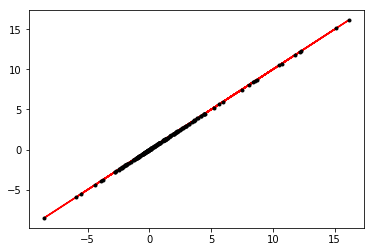

In [8]:
def comparison_plot(x, y):
    plt.plot(x, x, 'r')
    plt.plot(x, y, 'k.')
    
comparison_plot(opt_gmm_params['centroids'], reopt_gmm_params['centroids'])
np.max(np.abs((opt_gmm_params['centroids'] - reopt_gmm_params['centroids'])))

0.005187989649684699

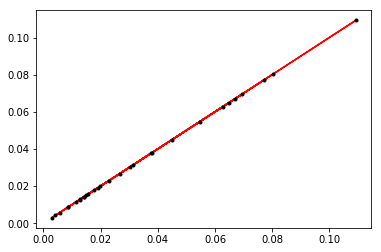

In [9]:
e_z0 = gmm.get_e_z(opt_gmm_params)
e_z1 = gmm.get_e_z(reopt_gmm_params)

comparison_plot(np.mean(e_z0, axis=0), np.mean(e_z1, axis=0))
np.max(np.abs(e_z0 - e_z1))

In [11]:
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_num_large_clusters_from_ez
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_number_clusters_from_logit_sticks

n_samples = 10000
threshold = 1
predictive = True

unif_samples = None
unv_norm_samples = None
if not predictive:
    unif_samples = np.random.random((gmm.num_obs, n_samples))
else:
    unv_norm_samples = np.random.normal(
        0, 1, size = (n_samples, num_components - 1))

def get_posterior_quantity(gmm_params):
    if not predictive:
        e_z = gmm.get_e_z(gmm_params)
        e_num, var_num = get_e_num_large_clusters_from_ez(
            e_z,
            threshold = threshold,
            n_samples = None,
            unif_samples = unif_samples)
    else:
        e_num = \
            get_e_number_clusters_from_logit_sticks(
                gmm_params['stick_propn_mean'],
                gmm_params['stick_propn_info'],
                n_obs = gmm.num_obs,
                threshold = threshold,
                n_samples = None,
                unv_norm_samples = unv_norm_samples)
    return e_num

get_posterior_quantity(opt_gmm_params)

29.687142990666803

In [12]:
e_num0 = get_posterior_quantity(opt_gmm_params)
e_num1 = get_posterior_quantity(reopt_gmm_params)
print('Refit e:\t{}\nOrig e: \t{}\nDifference:\t{}\n'.format(
    e_num1, e_num0, e_num1 - e_num0))

Refit e:	29.60373153467914
Orig e: 	29.687142990666803
Difference:	-0.08341145598766175



In [13]:
prior_free = False

get_kl_from_vb_free_prior_free = \
    paragami.FlattenFunctionInput(original_fun=
        gmm.get_params_prior_kl,
        patterns = [gmm.gmm_params_pattern, prior_params_pattern],
        free = [True, prior_free],
        argnums = [0, 1])

gmm.get_params_prior_kl(opt_gmm_params, prior_params)

get_kl_from_vb_free_prior_free(
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
    prior_params_pattern.flatten(prior_params, free=prior_free))

-44772.08376026973

In [14]:
taylor_order = 1
t0 = time.time()
vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        objective_function =    get_kl_from_vb_free_prior_free,
        input_val0 =            gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
        hyper_val0 =            prior_params_pattern.flatten(prior_params, free=prior_free),
        order =                 taylor_order,
        hess0 =                 kl_hess)
print('linear response Hessian time: {:.03f} secs'.format(time.time() - t0))

linear response Hessian time: 0.019 secs


/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/venv/lib/python3.5/site-packages/vittles/sensitivity_lib.py:857: UserWarning: The ParametricSensitivityTaylorExpansion is experimental.
  'The ParametricSensitivityTaylorExpansion is experimental.')


In [16]:
predict_gmm_params = \
    paragami.FoldFunctionInputAndOutput(
        original_fun=vb_sens.evaluate_taylor_series,
        input_patterns=prior_params_pattern,
        input_free=prior_free,
        input_argnums=[0],
        output_patterns=gmm.gmm_params_pattern,
        output_free=True,
        output_retnums=[0])

pred_gmm_params = predict_gmm_params(reopt_prior_params)

e_num_pred = get_posterior_quantity(pred_gmm_params)

print('Orig e: \t{}\nRefit e:\t{}\nPred e:\t\t{}\nActual diff:\t{:0.5}\nPred diff:\t{:0.5}'.format(
    e_num0, e_num1, e_num_pred,
    e_num1 - e_num0,
    e_num_pred - e_num0))

Orig e: 	29.687142990666803
Refit e:	29.60373153467914
Pred e:		29.61710689164945
Actual diff:	-0.083411
Pred diff:	-0.070036
